# Inspection

Here we can investigate the properties of each model that is made.

In [60]:
import ipywidgets as widgets
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as spi

from astropy.io import fits
from IPython.display import clear_output
from kosmatau3d import models
from pprint import pprint

%matplotlib inline

In [5]:
base_dir = '/mnt/hpc_backup/yanitski/projects/pdr/KT3_history/MilkyWay/'

Model

In [62]:
model = 'r400_fhi1.0_fuv1.0'

## Profiles

Here we simply want to examine to examine the various profiles we use to model the Milky Way.

In [6]:
data_dir = models.constants.INPUTPATH + 'MilkyWay/'

### Fix Bacchini et al. (2019) profiles

In [23]:
! ls {data_dir+'bacchini'}

h2_surf_dens.dat  hHE_H2_bin1kpc.txt  hHE_HI_bin1kpc.txt  hi_surf_dens.dat


In [52]:
! cat {data_dir+'bacchini/hHE_H2_bin1kpc.txt'}

# Scaleheights of H2 using the hydrostatic equilibrium in the MW gravitational potential using the model by MACMILLAN+2017. The velocity dispersion is taken from Marasco+2017 for R<8.3 kpc, beyond this it is fixed to 4\pm3 km/s for H2. The errors include only the uncertainty on the velocity dispersion, not on the mass distribution. 
#  1) R kpc 
#  2) h_h2 kpc 
#  3) lowe err kpc 
#  4) upper err kpc
1.000000000000000000e+00 2.135711840412908569e-02 5.219905484723261040e-03 4.782040749451908074e-03
2.000000000000000000e+00 2.655692361074707408e-02 2.059706375039820504e-03 2.082821415404307631e-03
3.000000000000000000e+00 3.057760027378623319e-02 3.261176549964303010e-03 3.348077406642010079e-03
4.000000000000000000e+00 3.397011314748997479e-02 3.599893052848884833e-03 3.679768521206656755e-03
5.000000000000000000e+00 3.730853273843366680e-02 3.927656370372275239e-03 3.726526482227944612e-03
6.000000000000000000e+00 4.116573201437213197e-02 4.148295505395217624e-03 4.144166804931238325e

In [53]:
h_h2 = pd.read_csv(data_dir + 'bacchini/hHE_H2_bin1kpc.txt', delim_whitespace=True, skiprows=5, names=['r', 'h_h2', 'sigma_h_l', 'sigma_h_u'])
h_h2_new = h_h2 * [1, 1000, 1000, 1000]
h_h2_new

,r,h_h2,sigma_h_l,sigma_h_u
0,1.0,21.357118,5.219905,4.782041
1,2.0,26.556924,2.059706,2.082821
2,3.0,30.577600,3.261177,3.348077
3,4.0,33.970113,3.599893,3.679769
4,5.0,37.308533,3.927656,3.726526
5,6.0,41.165732,4.148296,4.144167
6,7.0,46.089083,5.614142,5.653878
7,8.0,52.576154,10.438371,10.438371
8,9.0,61.050405,15.262601,15.262601
9,10.0,71.836887,17.959222,17.959222


In [54]:
h_h2_new.to_csv(data_dir + 'h2_scale-height_bacchini.dat', index=False, sep=' ')

### Append Marasco et al. (2017) surface mass density

In [37]:
sigma_h2_bacchini = pd.read_csv(data_dir + 'h2_surface-density_bacchini.dat', delim_whitespace=True, skiprows=1)
sigma_hi_bacchini = pd.read_csv(data_dir + 'hi_surface-density_bacchini.dat', delim_whitespace=True, skiprows=1)
sigma_hi_marasco = pd.read_csv(data_dir + 'marasco/MW_M17_HI.txt', delim_whitespace=True, skiprows=12, names=['r', 'v_rot', 'sigma', 'n', 'h', 'Sigma', 'v_err', 'sigma_err', 'n_err', 'h_err', 'Sigma_err'])
sigma_h2_marasco = pd.read_csv(data_dir + 'marasco/MW_M17_H2.txt', delim_whitespace=True, skiprows=12, names=['r', 'v_rot', 'sigma', 'n', 'h', 'Sigma', 'v_err', 'sigma_err', 'n_err', 'h_err', 'Sigma_err'])

i = sigma_hi_marasco.r.max()<sigma_hi_bacchini.r
sigma_r = pd.concat((sigma_hi_marasco.r, sigma_hi_bacchini.r.loc[i]))
sigma_Sigma = pd.concat((sigma_hi_marasco.Sigma, sigma_hi_bacchini.Sigma_hi.loc[i]))
sigma_l = pd.concat((sigma_hi_marasco.Sigma_err, sigma_hi_bacchini.sigma_Sigma_l.loc[i]))
sigma_u = pd.concat((sigma_hi_marasco.Sigma_err, sigma_hi_bacchini.sigma_Sigma_u.loc[i]))
df = pd.DataFrame(data={'r':sigma_r, 'Sigma_hi':sigma_Sigma, 'sigma_Sigma_l':sigma_l, 'sigma_Sigma_u':sigma_u})
df.to_csv(data_dir + 'hi_surface-density_marasco-bacchini.dat', index=False, sep=' ')

i = sigma_h2_marasco.r.max()<sigma_h2_bacchini.r
sigma_r = pd.concat((sigma_h2_marasco.r, sigma_h2_bacchini.r.loc[i]))
sigma_Sigma = pd.concat((sigma_h2_marasco.Sigma, sigma_h2_bacchini.Sigma_h2.loc[i]))
sigma_l = pd.concat((sigma_h2_marasco.Sigma_err, sigma_h2_bacchini.sigma_Sigma_l.loc[i]))
sigma_u = pd.concat((sigma_h2_marasco.Sigma_err, sigma_h2_bacchini.sigma_Sigma_u.loc[i]))
df = pd.DataFrame(data={'r':sigma_r, 'Sigma_h2':sigma_Sigma, 'sigma_Sigma_l':sigma_l, 'sigma_Sigma_u':sigma_u})
df.to_csv(data_dir + 'h2_surface-density_marasco-bacchini.dat', index=False, sep=' ')

### Scale height

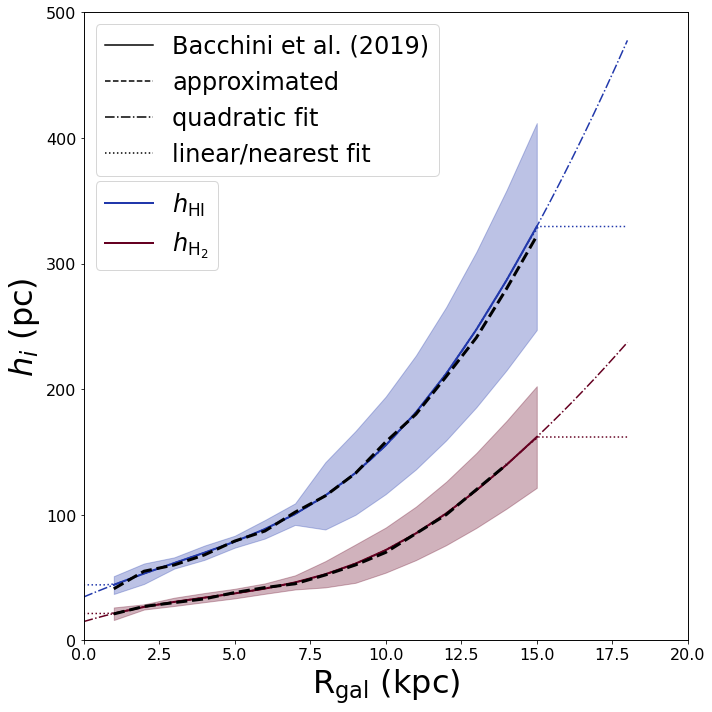

In [10]:
h_h2 = pd.read_csv(data_dir + 'h2_scale-height_bacchini.dat', delim_whitespace=True, skiprows=1)
h_hi = pd.read_csv(data_dir + 'hi_scale-height_bacchini.dat', delim_whitespace=True, skiprows=1)
h_h2_approx = pd.read_csv(data_dir + 'h2_scale-height_bacchini-approx.dat', delim_whitespace=True)
h_hi_approx = pd.read_csv(data_dir + 'hi_scale-height_bacchini-approx.dat', delim_whitespace=True)

r_new = np.linspace(0, 18)
f_h_hi = spi.interp1d(h_hi.r, h_hi.h_hi, kind='quadratic', fill_value='extrapolate')
f_h_h2 = spi.interp1d(h_h2.r, h_h2.h_h2, kind='quadratic', fill_value='extrapolate')

fig, ax = plt.subplots(figsize=(10, 10))
# HI
ax.fill_between(h_hi.r, h_hi.h_hi-h_hi.sigma_h_l, h_hi.h_hi+h_hi.sigma_h_u, color='xkcd:sapphire', alpha=0.3)
ax.plot(h_hi.r, h_hi.h_hi, c='xkcd:sapphire', lw=2, label=r'$h_\mathrm{HI}$')
ax.plot(r_new, f_h_hi(r_new), c='xkcd:sapphire', ls='-.')
ax.plot(r_new, np.interp(r_new, h_hi.r, h_hi.h_hi), c='xkcd:sapphire', ls=':')
ax.plot(h_hi_approx.r, h_hi_approx.h_hi, ls='--', lw=3, c='xkcd:black')
# H2
ax.fill_between(h_h2.r, h_h2.h_h2-h_h2.sigma_h_l, h_h2.h_h2+h_h2.sigma_h_u, color='xkcd:maroon', alpha=0.3)
ax.plot(h_h2.r, h_h2.h_h2, c='xkcd:maroon', lw=2, label=r'$h_\mathrm{H_2}$')
ax.plot(r_new, f_h_h2(r_new), c='xkcd:maroon', ls='-.')
ax.plot(r_new, np.interp(r_new, h_h2.r, h_h2.h_h2), c='xkcd:maroon', ls=':')
ax.plot(h_h2_approx.r, h_h2_approx.h_h2, ls='--', lw=3, c='xkcd:black')
ax.set_xlabel(r'R$_\mathrm{gal}$ (kpc)', fontsize=32)
ax.set_ylabel(r'$h_i$ (pc)', fontsize=32)
ax.set_xlim(0, 20)
ax.set_ylim(0, 500)
ax.legend(fontsize=24, loc=(0.02, 0.59))
ax2 = ax.twinx()
ax2.get_yaxis().set_visible(False)
ax2.plot([], [], c='xkcd:black', ls='-', label='Bacchini et al. (2019)')
ax2.plot([], [], c='xkcd:black', ls='--', label='approximated')
ax2.plot([], [], c='xkcd:black', ls='-.', label='quadratic fit')
ax2.plot([], [], c='xkcd:black', ls=':', label='linear/nearest fit')
ax2.legend(fontsize=24, loc='upper left')
ax.tick_params(labelsize=16)
fig.tight_layout()
plt.savefig('plots/scale-height_dist.png') ;

### Surface mass density

In [8]:
sigma_h2_mb

,r,Sigma_h2,sigma_Sigma_l,sigma_Sigma_u
0,0.05,1.105570e+02,3.497080e+01,3.497080e+01
1,0.25,5.820600e+01,2.049480e+01,2.049480e+01
2,0.45,1.268500e+01,5.392500e+00,5.392500e+00
3,0.65,6.964000e+00,2.397000e+00,2.397000e+00
4,0.85,4.746000e+00,2.384800e+00,2.384800e+00
5,1.05,2.022000e+00,1.018300e+00,1.018300e+00
6,1.25,1.444000e+00,6.394000e-01,6.394000e-01
7,1.45,1.425000e+00,6.396000e-01,6.396000e-01
8,1.65,1.068000e+00,5.559000e-01,5.559000e-01
9,1.85,7.730000e-01,3.742000e-01,3.742000e-01


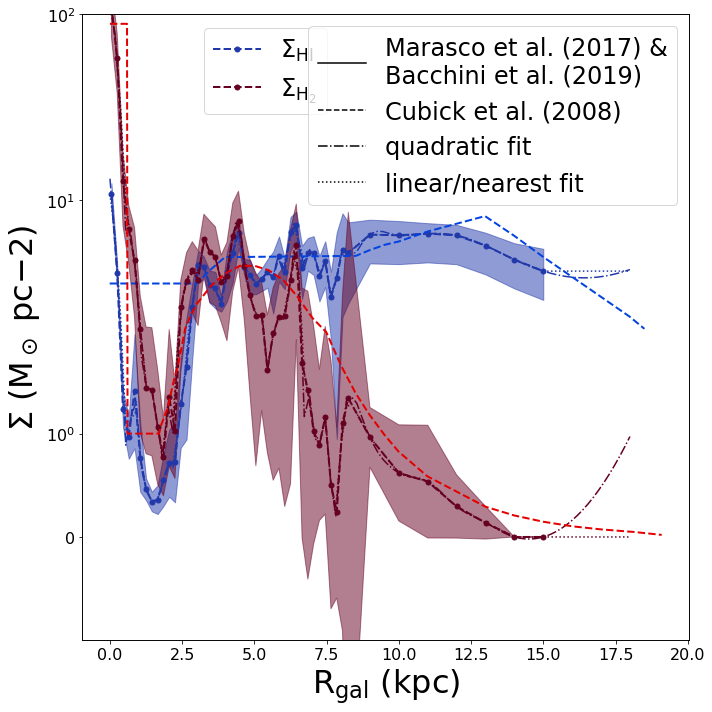

In [13]:
sigma_h2_bacchini = pd.read_csv(data_dir + 'h2_surface-density_bacchini.dat', delim_whitespace=True, skiprows=1)
sigma_hi_bacchini = pd.read_csv(data_dir + 'hi_surface-density_bacchini.dat', delim_whitespace=True, skiprows=1)
sigma_h2_wolfire = pd.read_csv(data_dir + 'h2_surface-density_wolfire.dat', delim_whitespace=True, names=['r', 'Sigma_h2'], skiprows=1)
sigma_hi_wolfire = pd.read_csv(data_dir + 'hi_surface-density_wolfire.dat', delim_whitespace=True, names=['r', 'Sigma_hi'], skiprows=1)
#sigma_hi_marasco = pd.read_csv(data_dir + 'marasco/MW_M17_HI.txt', delim_whitespace=True, skiprows=12, names=['r', 'v_rot', 'sigma', 'n', 'h', 'Sigma', 'v_err', 'sigma_err', 'n_err', 'h_err', 'Sigma_err'])
#sigma_h2_marasco = pd.read_csv(data_dir + 'marasco/MW_M17_H2.txt', delim_whitespace=True, skiprows=12, names=['r', 'v_rot', 'sigma', 'n', 'h', 'Sigma', 'v_err', 'sigma_err', 'n_err', 'h_err', 'Sigma_err'])
sigma_h2_mb = pd.read_csv(data_dir + 'h2_surface-density_marasco-bacchini.dat', delim_whitespace=True, skiprows=1)
sigma_hi_mb = pd.read_csv(data_dir + 'hi_surface-density_marasco-bacchini.dat', delim_whitespace=True, skiprows=1)

r_new = np.linspace(0, 18, num=100)
f_sig_hi = spi.interp1d(sigma_hi_mb.r, sigma_hi_mb.Sigma_hi, kind='quadratic', fill_value='extrapolate')
f_sig_h2 = spi.interp1d(sigma_h2_mb.r, sigma_h2_mb.Sigma_h2, kind='quadratic', fill_value='extrapolate')

fig, ax = plt.subplots(figsize=(10, 10))

# HI
#ax.fill_between(sigma_hi_bacchini.r, sigma_hi_bacchini.Sigma_hi-sigma_hi_bacchini.sigma_Sigma_l, 
#                sigma_hi_bacchini.Sigma_hi+sigma_hi_bacchini.sigma_Sigma_u, color='xkcd:sapphire', alpha=0.3)
#ax.plot(sigma_hi_bacchini.r, sigma_hi_bacchini.Sigma_hi, c='xkcd:sapphire', lw=2, marker='o', label=r'$\Sigma_\mathrm{HI}$')
ax.fill_between(sigma_hi_mb.r, sigma_hi_mb.Sigma_hi-sigma_hi_mb.sigma_Sigma_l, 
                sigma_hi_mb.Sigma_hi+sigma_hi_mb.sigma_Sigma_u, color='xkcd:sapphire', alpha=0.5)
ax.plot(sigma_hi_mb.r, sigma_hi_mb.Sigma_hi, ls='--', lw=2, marker='o', ms=5, c='xkcd:sapphire', label=r'$\Sigma_\mathrm{HI}$')
ax.plot(r_new, f_sig_hi(r_new), c='xkcd:sapphire', ls='-.')
ax.plot(r_new, np.interp(r_new, sigma_hi_mb.r, sigma_hi_mb.Sigma_hi), c='xkcd:sapphire', ls=':')
ax.plot(sigma_hi_wolfire.r, sigma_hi_wolfire.Sigma_hi, ls='--', lw=2, c='xkcd:blue')
# H2
#ax.fill_between(sigma_h2_bacchini.r, sigma_h2_bacchini.Sigma_h2-sigma_h2_bacchini.sigma_Sigma_l, 
#                sigma_h2_bacchini.Sigma_h2+sigma_h2_bacchini.sigma_Sigma_u, color='xkcd:maroon', alpha=0.3)
#ax.plot(sigma_h2_bacchini.r, sigma_h2_bacchini.Sigma_h2, c='xkcd:maroon', lw=2, marker='o', label=r'$\Sigma_\mathrm{H_2}$')
ax.fill_between(sigma_h2_mb.r, sigma_h2_mb.Sigma_h2-sigma_h2_mb.sigma_Sigma_l, 
                sigma_h2_mb.Sigma_h2+sigma_h2_mb.sigma_Sigma_u, color='xkcd:maroon', alpha=0.5)
ax.plot(sigma_h2_mb.r, sigma_h2_mb.Sigma_h2, ls='--', lw=2, marker='o', ms=5, c='xkcd:maroon', label=r'$\Sigma_\mathrm{H_2}$')
ax.plot(r_new, f_sig_h2(r_new), c='xkcd:maroon', ls='-.')
ax.plot(r_new, np.interp(r_new, sigma_h2_mb.r, sigma_h2_mb.Sigma_h2), c='xkcd:maroon', ls=':')
ax.plot(sigma_h2_wolfire.r, sigma_h2_wolfire.Sigma_h2, ls='--', lw=2, c='xkcd:red')

ax.set_xlabel(r'R$_\mathrm{gal}$ (kpc)', fontsize=32)
ax.set_ylabel(r'$\Sigma$ (M$_\odot$ pc${-2}$)', fontsize=32)
ax.legend(fontsize=24, loc=(0.20, 0.84))
ax.set_ylim(-1e0, 1e2)
ax.set_yscale('symlog')
ax2 = ax.twinx()
ax2.get_yaxis().set_visible(False)
ax2.plot([], [], c='xkcd:black', ls='-', label='Marasco et al. (2017) &\nBacchini et al. (2019)')
ax2.plot([], [], c='xkcd:black', ls='--', label='Cubick et al. (2008)')
ax2.plot([], [], c='xkcd:black', ls='-.', label='quadratic fit')
ax2.plot([], [], c='xkcd:black', ls=':', label='linear/nearest fit')
ax2.legend(fontsize=24, loc='upper right')
ax.tick_params(labelsize=16)
fig.tight_layout()
plt.savefig('plots/surface-density_dist.png') ;

### Volume mass density

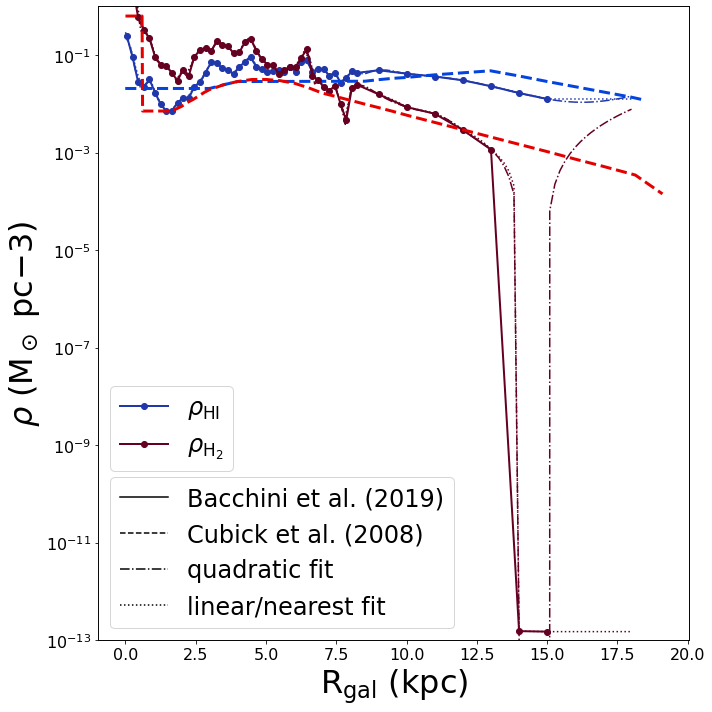

In [16]:
rho_h2_wolfire = pd.read_csv(data_dir + 'h2_mass-density_wolfire-approx.dat', delim_whitespace=True, names=['r', 'rho_h2'], skiprows=1)
rho_hi_wolfire = pd.read_csv(data_dir + 'hi_mass-density_wolfire-approx.dat', delim_whitespace=True, names=['r', 'rho_hi'], skiprows=1)
sigma_h2_bacchini = pd.read_csv(data_dir + 'h2_surface-density_marasco-bacchini.dat', delim_whitespace=True, skiprows=1)
sigma_hi_bacchini = pd.read_csv(data_dir + 'hi_surface-density_marasco-bacchini.dat', delim_whitespace=True, skiprows=1)
h_h2 = pd.read_csv(data_dir + 'h2_scale-height_bacchini.dat', delim_whitespace=True, skiprows=1)
h_hi = pd.read_csv(data_dir + 'hi_scale-height_bacchini.dat', delim_whitespace=True, skiprows=1)
rho_h2_bacchini = pd.DataFrame(data={'r':sigma_h2_bacchini.r, 'rho_h2':sigma_h2_bacchini.Sigma_h2/np.interp(sigma_h2_bacchini.r, h_h2.r, h_h2.h_h2)})
rho_hi_bacchini = pd.DataFrame(data={'r':sigma_hi_bacchini.r, 'rho_hi':sigma_hi_bacchini.Sigma_hi/np.interp(sigma_hi_bacchini.r, h_hi.r, h_hi.h_hi)})

r_new = np.linspace(0, 18, num=100)
f_rho_hi = spi.interp1d(rho_hi_bacchini.r, rho_hi_bacchini.rho_hi, kind='quadratic', fill_value='extrapolate')
f_rho_h2 = spi.interp1d(rho_h2_bacchini.r, rho_h2_bacchini.rho_h2, kind='quadratic', fill_value='extrapolate')

fig, ax = plt.subplots(figsize=(10, 10))

# HI
plt.plot(rho_hi_bacchini.r, rho_hi_bacchini.rho_hi, c='xkcd:sapphire', lw=2, marker='o', label=r'$\rho_\mathrm{HI}$')
plt.plot(r_new, f_rho_hi(r_new), c='xkcd:sapphire', ls='-.')
plt.plot(r_new, np.interp(r_new, rho_hi_bacchini.r, rho_hi_bacchini.rho_hi), c='xkcd:sapphire', ls=':')
plt.plot(rho_hi_wolfire.r, rho_hi_wolfire.rho_hi, c='xkcd:blue', lw=3, ls='--')
# H2
plt.plot(rho_h2_bacchini.r, rho_h2_bacchini.rho_h2, c='xkcd:maroon', lw=2, marker='o', label=r'$\rho_\mathrm{H_2}$')
plt.plot(r_new, f_rho_h2(r_new), c='xkcd:maroon', ls='-.')
plt.plot(r_new, np.interp(r_new, rho_h2_bacchini.r, rho_h2_bacchini.rho_h2), c='xkcd:maroon', ls=':')
plt.plot(rho_h2_wolfire.r, rho_h2_wolfire.rho_h2, c='xkcd:red', lw=3, ls='--')

ax.set_xlabel(r'R$_\mathrm{gal}$ (kpc)', fontsize=32)
ax.set_ylabel(r'$\rho$ (M$_\odot$ pc${-3}$)', fontsize=32)
ax.legend(fontsize=24, loc=(0.02, 0.267))
ax.set_ylim(1e-13, 1e0)
#ax.set_yticklabels(10**np.arange(-1, 1, dtype=float))
ax.set_yscale('log')
ax2 = ax.twinx()
ax2.get_yaxis().set_visible(False)
ax2.plot([], [], c='xkcd:black', ls='-', label='Bacchini et al. (2019)')
ax2.plot([], [], c='xkcd:black', ls='--', label='Cubick et al. (2008)')
ax2.plot([], [], c='xkcd:black', ls='-.', label='quadratic fit')
ax2.plot([], [], c='xkcd:black', ls=':', label='linear/nearest fit')
ax2.legend(fontsize=24, loc='lower left')
ax.tick_params(labelsize=16)
fig.tight_layout()
plt.savefig('plots/volume-density_dist.png') ;

### Number density

In [132]:
Msolpc2ncm

38.31953615276118

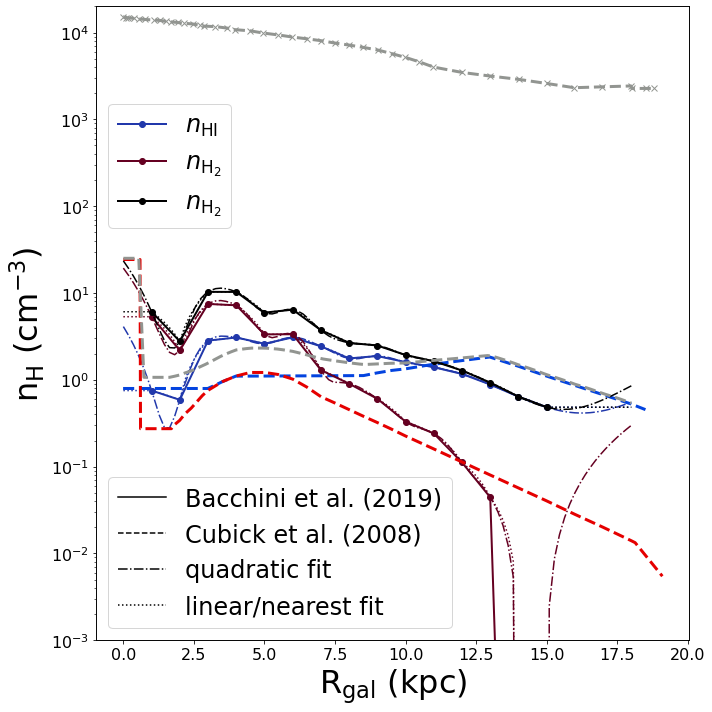

In [26]:
n_wolfire = pd.read_csv(data_dir + 'h_number-density_cubick.dat', delim_whitespace=True, names=['r', 'density'], skiprows=1)
rho_h2_wolfire = pd.read_csv(data_dir + 'h2_mass-density_wolfire-approx.dat', delim_whitespace=True, names=['r', 'rho_h2'], skiprows=1)
rho_hi_wolfire = pd.read_csv(data_dir + 'hi_mass-density_wolfire-approx.dat', delim_whitespace=True, names=['r', 'rho_hi'], skiprows=1)
sigma_h2_bacchini = pd.read_csv(data_dir + 'h2_surface-density_bacchini.dat', delim_whitespace=True, skiprows=1)
sigma_hi_bacchini = pd.read_csv(data_dir + 'hi_surface-density_bacchini.dat', delim_whitespace=True, skiprows=1)
h_h2 = pd.read_csv(data_dir + 'h2_scale-height_bacchini.dat', delim_whitespace=True, skiprows=1)
h_hi = pd.read_csv(data_dir + 'hi_scale-height_bacchini.dat', delim_whitespace=True, skiprows=1)
Msolpc2ncm = 1.8841e33/1.673e-24/(3.086e18)**3
n_h2_bacchini = pd.DataFrame(data={'r':h_h2.r, 'n_h2':sigma_h2_bacchini.Sigma_h2/h_h2.h_h2*Msolpc2ncm})
n_hi_bacchini = pd.DataFrame(data={'r':h_hi.r, 'n_hi':sigma_hi_bacchini.Sigma_hi/h_hi.h_hi*Msolpc2ncm})

r_new = np.linspace(0, 18, num=100)
f_n_hi = spi.interp1d(n_hi_bacchini.r, n_hi_bacchini.n_hi, kind='quadratic', fill_value='extrapolate')
f_n_h2 = spi.interp1d(n_h2_bacchini.r, n_h2_bacchini.n_h2, kind='quadratic', fill_value='extrapolate')

fig, ax = plt.subplots(figsize=(10, 10))

# HI
plt.plot(n_hi_bacchini.r, n_hi_bacchini.n_hi, c='xkcd:sapphire', lw=2, marker='o', label=r'$n_\mathrm{HI}$')
plt.plot(r_new, f_n_hi(r_new), c='xkcd:sapphire', ls='-.')
plt.plot(r_new, np.interp(r_new, n_hi_bacchini.r, n_hi_bacchini.n_hi), c='xkcd:sapphire', ls=':')
plt.plot(rho_hi_wolfire.r, rho_hi_wolfire.rho_hi*Msolpc2ncm, c='xkcd:blue', lw=3, ls='--')
# H2
plt.plot(n_h2_bacchini.r, n_h2_bacchini.n_h2, c='xkcd:maroon', lw=2, marker='o', label=r'$n_\mathrm{H_2}$')
plt.plot(r_new, f_n_h2(r_new), c='xkcd:maroon', ls='-.')
plt.plot(r_new, np.interp(r_new, n_h2_bacchini.r, n_h2_bacchini.n_h2), c='xkcd:maroon', ls=':')
plt.plot(rho_h2_wolfire.r, rho_h2_wolfire.rho_h2*Msolpc2ncm, c='xkcd:red', lw=3, ls='--')
# H
plt.plot(n_h2_bacchini.r, n_hi_bacchini.n_hi+n_h2_bacchini.n_h2, c='xkcd:black', lw=2, marker='o', label=r'$n_\mathrm{H_2}$')
plt.plot(r_new, f_n_hi(r_new)+f_n_h2(r_new), c='xkcd:black', ls='-.')
plt.plot(r_new, np.interp(r_new, n_hi_bacchini.r, n_hi_bacchini.n_hi)+np.interp(r_new, n_h2_bacchini.r, n_h2_bacchini.n_h2), 
                          c='xkcd:black', ls=':')
plt.plot(r_new, (np.interp(r_new, rho_hi_wolfire.r, rho_hi_wolfire.rho_hi)
                 + np.interp(r_new, rho_h2_wolfire.r, rho_h2_wolfire.rho_h2))*Msolpc2ncm, c='xkcd:grey', lw=3, ls='--')
plt.plot(n_wolfire.r, n_wolfire.density, c='xkcd:grey', marker='x', lw=3, ls='--')

ax.set_xlabel(r'R$_\mathrm{gal}$ (kpc)', fontsize=32)
ax.set_ylabel(r'n$_\mathrm{H}$ (cm$^{-3}$)', fontsize=32)
ax.legend(fontsize=24, loc=(0.02, 0.65))
ax.set_ylim(1e-3, 2e4)
#ax.set_yticklabels(10**np.arange(-1, 1, dtype=float))
ax.set_yscale('log')
ax2 = ax.twinx()
ax2.get_yaxis().set_visible(False)
ax2.plot([], [], c='xkcd:black', ls='-', label='Bacchini et al. (2019)')
ax2.plot([], [], c='xkcd:black', ls='--', label='Cubick et al. (2008)')
ax2.plot([], [], c='xkcd:black', ls='-.', label='quadratic fit')
ax2.plot([], [], c='xkcd:black', ls=':', label='linear/nearest fit')
ax2.legend(fontsize=24, loc='lower left')
ax.tick_params(labelsize=16)
fig.tight_layout()
plt.savefig('plots/density_dist.png');

### with `kosmatau3d`

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.interpolate as interpolate

from kosmatau3d import models

%matplotlib inline

In [2]:
parameters = {
                # Data files
                'tau_grid_file': 'clump_tau_LineCenter.dat',
                'tb_grid_file': 'clump_Tmb_LineCenter.dat',
                'tau_fuv_grid_file': 'RhoMassAFUV.dat',
                'h2_surface_density_file': 'h2_surface-density_marasco-bacchini.dat', 
                'hi_surface_density_file': 'hi_surface-density_marasco-bacchini.dat', 
                'h2_scale_height_file': 'h2_scale-height_bacchini.dat', 
                'hi_scale_height_file': 'hi_scale-height_bacchini.dat', 
                'like_clumps': False,
                'scale_gc': 10, 
                'h_number_density_file': 'h_number-density_cubick.dat',
                'fuv_file': 'galactic_FUV_complete.dat',
                'average_fuv': False,
                'l_range': (912, 2066),
                
                # Model information
                'history_path': r'/home/yanitski/projects/pdr/KT3_history',
                'directory': r'/MilkyWay',
                'x': 36,
                'y': 36,
                'z': 0,
                'model_type': 'disk',
  
                # Model parameters
                'resolution': 400,
                # 'molecules': 'all',
                'molecules': ['C+ 1', 
                              'C 1', 'C 2', 
                              'CO 1', 'CO 2', 'CO 3', 'CO 4', 'CO 5', 
                              'CO 6', 'CO 7', 'CO 8', 
                              '13C+ 1', 
                              '13C 1', '13C 2', 
                              '13CO 1', '13CO 2', '13CO 3', '13CO 4', '13CO 5', 
                              '13CO 6', '13CO 7', '13CO 8', 
                              'HCO+ 1', 'HCO+ 2', 'HCO+ 3', 'HCO+ 4', 'HCO+ 5'],
                # 'dust': 'PAH',
                'dust': ['240um', '550um'],
                'clump_mass_range': [[0, 2], [-2]],
                'clump_mass_number': [3, 1],
                'clump_n_max': [1, 100],
                'clump_log_fuv' : None,
                'interclump_log_fuv' : None,
                'velocity_range': [-350, 350],
                'velocity_number': 701,
  
                # Flags
                'suggested_calc': True,
                'dilled': False,
  
                # Property factors
                'hi_mass_factor': 1,
                'h2_mass_factor': 1,
                'ensemble_mass_factor': [1, 1],
                'fuv_factor': 1,
                'density_factor': 1,
                'interclump_hi_ratio': 1,
                'r_cmz': 0,
  
                # Logging
                'timed': False,
                'debug': False,
                'verbose': False
}
kosmatau = models.Model(**parameters)
data_dir = models.constants.INPUTPATH + 'MilkyWay/'

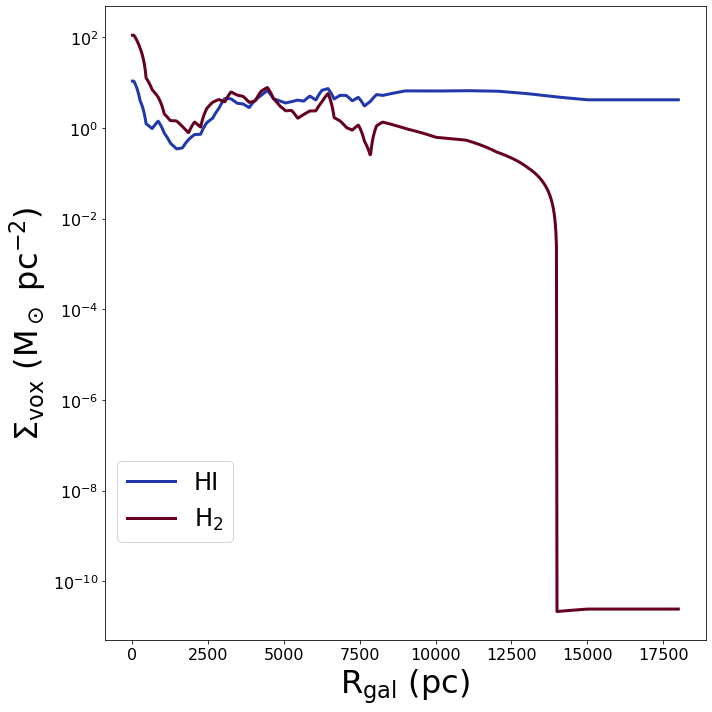

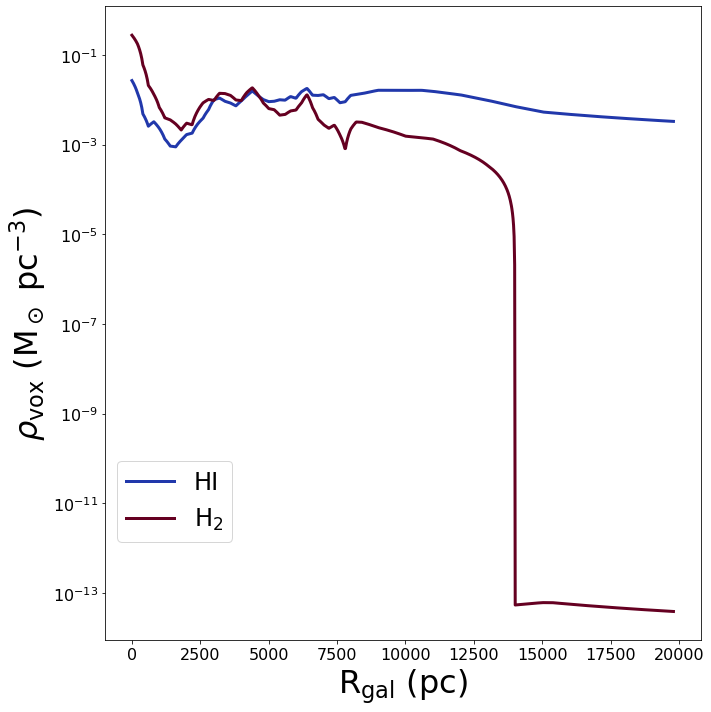

In [11]:
sigma_h2_bacchini = pd.read_csv(data_dir + 'h2_surface-density_marasco-bacchini.dat', delim_whitespace=True, skiprows=1)
sigma_hi_bacchini = pd.read_csv(data_dir + 'hi_surface-density_marasco-bacchini.dat', delim_whitespace=True, skiprows=1)

r_new = np.linspace(0, 18000, num=1000)
interp_sigma_h2 = interpolate.interp1d(sigma_h2_bacchini.r*1000, sigma_h2_bacchini.Sigma_h2, bounds_error=False, 
                                       fill_value=(sigma_h2_bacchini.Sigma_h2.iloc[0], sigma_h2_bacchini.Sigma_h2.iloc[-1]))
interp_sigma_hi = interpolate.interp1d(sigma_hi_bacchini.r*1000, sigma_hi_bacchini.Sigma_hi, bounds_error=False, 
                                       fill_value=(sigma_hi_bacchini.Sigma_hi.iloc[0], sigma_hi_bacchini.Sigma_hi.iloc[-1]))

fig1, ax1 = plt.subplots(figsize=(10, 10))
ax1.semilogy(r_new, interp_sigma_hi(r_new), c='xkcd:sapphire', lw=3, label=r'HI')
ax1.semilogy(r_new, interp_sigma_h2(r_new), c='xkcd:maroon', lw=3, label=r'H$_2$')
ax1.set_xlabel(r'R$_\mathrm{gal}$ (pc)', fontsize=32)
ax1.set_ylabel(r'$\Sigma_\mathrm{vox}$ (M$_\odot$ pc$^{-2}$)', fontsize=32)
ax1.legend(fontsize=24, loc=(0.02, 0.155))
ax1.tick_params(labelsize=16)
fig1.tight_layout()
plt.savefig('plots/surface-density_dist.png', facecolor='white')

ds = 400
r_new = np.linspace(0, 20000, num=1000)
z_new = np.zeros_like(r_new)
hi_mass = models.interpolations.hi_mass_interpolation(r_new, z_new)
h2_mass = models.interpolations.h2_mass_interpolation(r_new, z_new)

fig2, ax2 = plt.subplots(figsize=(10, 10))
ax2.semilogy(r_new, hi_mass/ds**3, c='xkcd:sapphire', lw=3, label=r'HI')
ax2.semilogy(r_new, h2_mass/ds**3, c='xkcd:maroon', lw=3, label=r'H$_2$')
ax2.set_xlabel(r'R$_\mathrm{gal}$ (pc)', fontsize=32)
ax2.set_ylabel(r'$\rho_\mathrm{vox}$ (M$_\odot$ pc$^{-3}$)', fontsize=32)
ax2.legend(fontsize=24, loc=(0.02, 0.155))
ax2.tick_params(labelsize=16)
fig2.tight_layout()
plt.savefig('plots/volume-density_dist.png', facecolor='white')

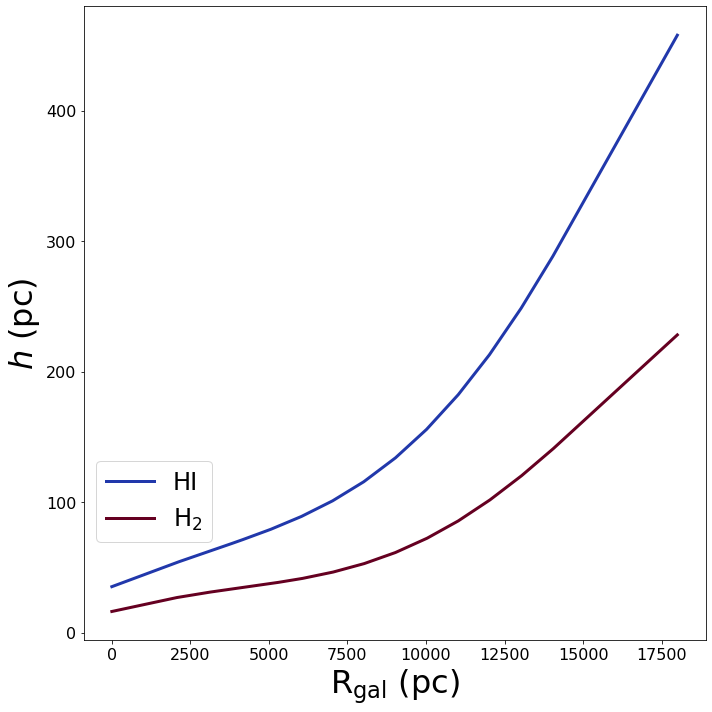

In [14]:
r_new = np.linspace(0, 18000, num=1000)
hi_height = models.interpolations.hi_scale_height(r_new)
h2_height = models.interpolations.h2_scale_height(r_new)

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(r_new, hi_height, c='xkcd:sapphire', lw=3, label=r'HI')
ax.plot(r_new, h2_height, c='xkcd:maroon', lw=3, label=r'H$_2$')
ax.set_xlabel(r'R$_\mathrm{gal}$ (pc)', fontsize=32)
ax.set_ylabel(r'$h$ (pc)', fontsize=32)
ax.legend(fontsize=24, loc=(0.02, 0.155))
ax.tick_params(labelsize=16)
fig.tight_layout()
plt.savefig('plots/scale-height_dist.png', facecolor='white')

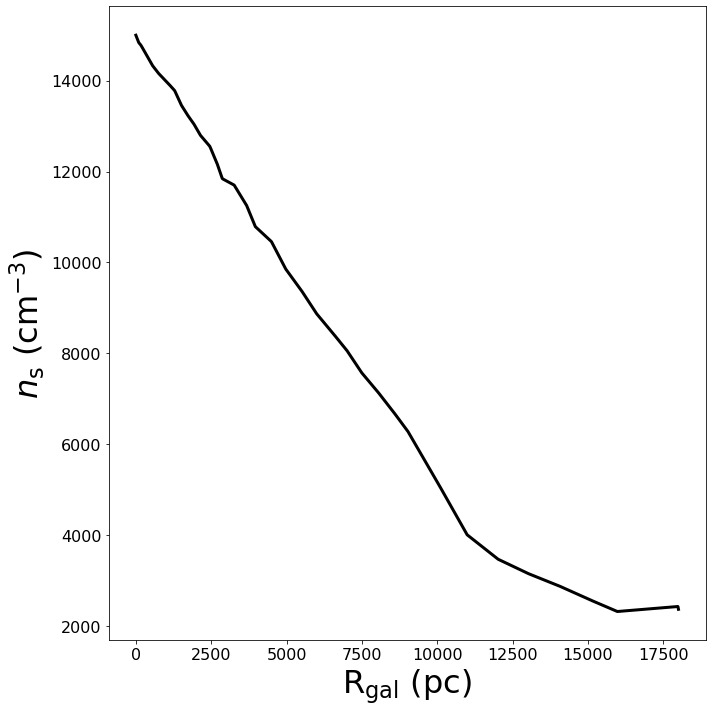

In [12]:
r_new = np.linspace(0, 18000, num=1000)
clump_density = models.interpolations.number_density_interpolation(r_new)

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(r_new, clump_density, c='xkcd:black', lw=3, label=r'$n_\mathrm{s}$')
ax.set_xlabel(r'R$_\mathrm{gal}$ (pc)', fontsize=32)
ax.set_ylabel(r'$n_\mathrm{s}$ (cm$^{-3}$)', fontsize=32)
#ax.legend(fontsize=24, loc=(0.02, 0.155))
ax.tick_params(labelsize=16)
fig.tight_layout()
plt.savefig('plots/clump-density_dist.png', facecolor='white')

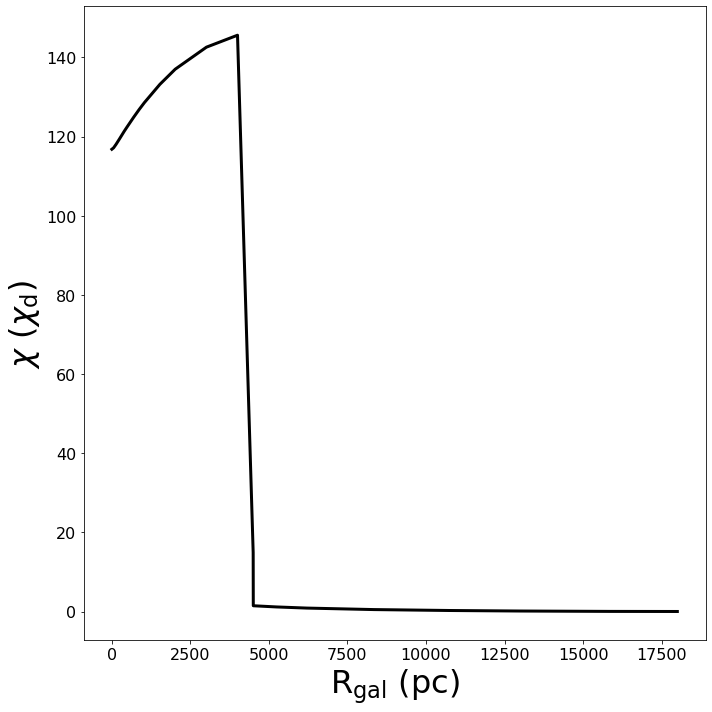

In [10]:
r_new = np.linspace(0, 18000, num=10000)
z_new = np.zeros_like(r_new)
fuv = models.interpolations.fuv_interpolation(r_new, z_new)

fuv[r_new <= 4500] = fuv[r_new <= 4500]*10

fig, ax = plt.subplots(figsize=(10, 10))
#ax.plot(r_new, hi_height, c='xkcd:sapphire', lw=3, label=r'HI')
ax.plot(r_new, fuv, c='xkcd:black', lw=3, label=r'far-UV')
# ax.plot([4504, 4504], [0, 15], lw=1, ls='--', color='xkcd:vomit')
ax.set_xlabel(r'R$_\mathrm{gal}$ (pc)', fontsize=32)
ax.set_ylabel(r'$\chi$ ($\chi_\mathrm{d}$)', fontsize=32)
#ax.legend(fontsize=24, loc=(0.02, 0.155))
ax.tick_params(labelsize=16)
fig.tight_layout()
plt.savefig('plots/fuv_dist.png', facecolor='white')

### far-UV

In [49]:
np.asarray(u_l).shape, np.asarray(l).shape

((9, 23), (9,))

In [58]:
np.asarray(l)

array([ 912, 1350, 1500, 1650, 2000, 2200, 2500, 2800, 3650])

In [68]:
! cat {data_dir + 'galactic_FUV_complete.dat'}

#Header: r[pc] then galactic radiation-field energy-density distributions [erg/pc^3/A] avg and for different wavelenghts [Avg][ 912 1350 1500 1650 2000 2200 2500 2800 3650]
0.0	0.0	6.2469530653e+42	3.5408648e+39	3.0322014e+39	2.7879367e+39	2.1613113e+39	1.8412485e+39	1.6516819e+39	1.6321422e+39	2.3964024e+39	1.9639536e+39
0.0	50.0	5.0253700416e+42	2.825264e+39	2.4296424e+39	2.2472454e+39	1.7274575e+39	1.4565022e+39	1.3529016e+39	1.3555341e+39	1.9944285e+39	1.4850613e+39
0.0	100.0	3.57993663625e+42	1.9535837e+39	1.7149073e+39	1.6177966e+39	1.2177548e+39	1.0037844e+39	9.8629948e+38	1.0164931e+39	1.5472977e+39	9.0247337e+38
0.0	150.0	2.7950426938e+42	1.5075442e+39	1.339665e+39	1.2791765e+39	9.3113465e+38	7.4947858e+38	7.6533404e+38	8.119976e+38	1.2881593e+39	6.2267734e+38
0.0	200.0	2.4052935314e+42	1.2926422e+39	1.1571369e+39	1.1091627e+39	7.8430723e+38	6.2155458e+38	6.52356e+38	7.029535e+38	1.1529708e+39	4.9810508e+38
0.0	300.0	2.0958113267e+42	1.1228971e+39	1.0113032e+39	9.7181178e+38	6

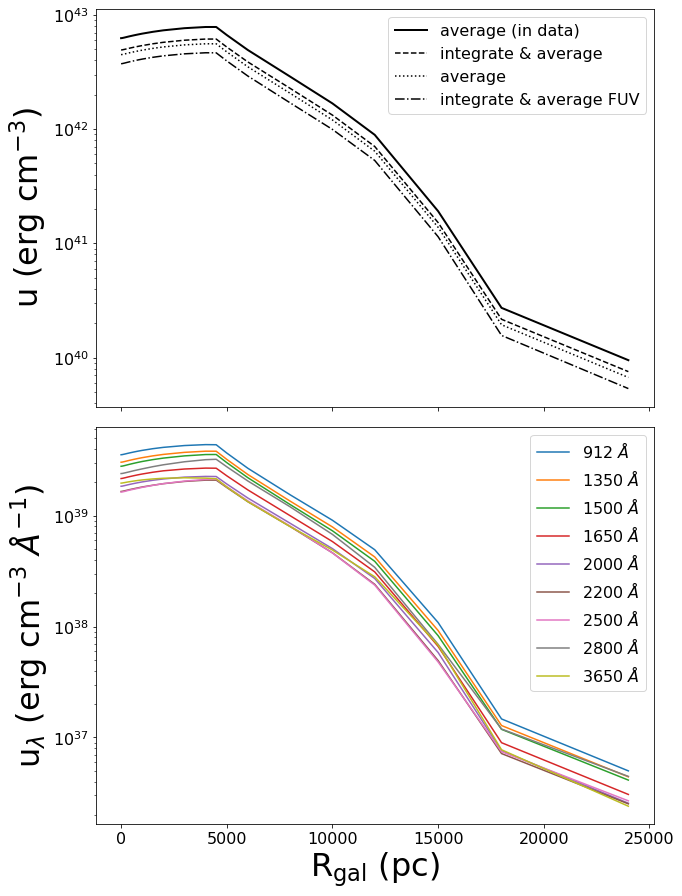

In [72]:
from scipy import interpolate

cols = ['r', 'z', 'average', '912', '1350', '1500', '1650', '2000', '2200', '2500', '2800', '3650']
fuv = pd.read_csv(data_dir + 'galactic_FUV_complete.dat', delim_whitespace=True, names=cols, skiprows=1)
fuv0 = fuv.loc[fuv.z==0]

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'hspace':0.05}, figsize=(10, 15))
#fuv.groupby('r').max().reset_index().plot(x='r', y='average', ax=ax1, title='Far-UV radiation at b=0', fontsize=14)
#fuv.groupby('r').max().reset_index().plot(x='r', y=[r'912 $\AA$', r'1350 $\AA$', r'1500 $\AA$', r'1650 $\AA$', r'2000 $\AA$', r'2200 $\AA$', r'2500 $\AA$', r'2800 $\AA$', r'3650 $\AA$'], ax=ax2, fontsize=14)
ax1.plot(fuv0.r, fuv0.average, c='xkcd:black', lw=2, label='average (in data)')
u_l = np.array([fuv0[_].values*int(_) for _ in cols[3:]])
l = np.array([int(_) for _ in cols[3:]])
f_u = interpolate.interp1d(l, u_l, axis=0)
ax1.semilogy(fuv0.r, np.trapz(u_l, x=l, axis=0)/(l[-1]-l[0]), c='xkcd:black', ls='--', label='integrate & average')
ax1.semilogy(fuv0.r, np.mean(u_l, axis=0), c='xkcd:black', ls=':', label='average')
l_new = np.linspace(912, 2200, num=1000)
ax1.semilogy(fuv0.r, np.trapz(f_u(l_new), l_new, axis=0)/(2200-912), c='xkcd:black', ls='-.', label='integrate & average FUV')
ax1.legend(fontsize=16)
for wav in cols[3:]:
    ax2.semilogy(fuv0.r, fuv0[wav], label=wav+r' $\AA$')
ax2.legend(fontsize=16)
ax2.set_xlabel(r'R$_\mathrm{gal}$ (pc)', fontsize=32)
ax1.set_ylabel(r'u (erg cm$^{-3}$)', fontsize=32)
ax2.set_ylabel(r'u$_\lambda$ (erg cm$^{-3}$ $\AA^{-1}$)', fontsize=32)
ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
#fig.tight_layout()
plt.savefig('plots/fuv_dist.png');

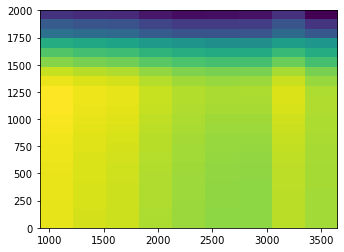

In [121]:
plt.imshow(np.log10(fuv.groupby('r').max()[[912, 1350, 1500, 1650, 2000, 2200, 2500, 2800, 3650]]).to_numpy()[::-1, :], extent=(912, 3650, 0, 2000))

In [ ]:
list(_ if _<3 else -10 if _>6 else np.nan for _ in range(10))

[0, 1, 2, nan, nan, nan, nan, -10, -10, -10]

In [ ]:
r = np.hstack((hi_mass['r2'], hi_mass['r2'], hi_mass['r2']))
z = np.hstack((np.zeros_like(hi_mass['HI mass'], dtype=float), np.full_like(hi_mass['HI mass'], 50, dtype=float), np.full_like(hi_mass['HI mass'], 100, dtype=float)))
m = np.hstack((hi_mass['HI mass'], .5*hi_mass['HI mass'], .3*hi_mass['HI mass']))
data = pd.DataFrame(data={'R(pc)':r*1000, 'h(pc)':z, 'M(M_sol)':m})
data

,R(pc),h(pc),M(M_sol)
0,-10.0,0.0,0.020747
1,97.2,0.0,0.020747
2,1191.2,0.0,0.020747
3,2990.3,0.0,0.020747
4,3233.4,0.0,0.022521
...,...,...,...
58,15000.0,100.0,0.008643
59,15996.8,100.0,0.006756
60,16993.5,100.0,0.005282
61,17990.3,100.0,0.004129


## Distributions

### Mass

In [63]:
positions = fits.open(base_dir + model + '/voxel_position.fits')
mass = fits.open(base_dir + model + '/voxel_ensemble_mass.fits')

In [64]:
mass[0].data.sum(1).shape, x.shape

NameError: name 'x' is not defined

In [15]:
z.max()

1.0

In [65]:
x, y, z = positions[0].data.T
z = np.random.rand(z.size)
values = mass[0].data.sum(1)*400
fig = go.Figure(data=go.Volume(x=x, 
                               y=y, 
                               z=z, 
                               value=values, 
                               isomin=0, 
                               isomax=values.max(), 
                               opacity=0.5, 
                               surface_count=50))

In [ ]:
fig.show()

### Intensity

In [31]:
intensity = fits.open(base_dir + model + '/synthetic_intensity.fits')
# pprint(intensity[1].header)

In [26]:
lon = np.linspace(intensity[1].header['CRVAL2'] - (intensity[1].header['CRPIX2']-0.5)*intensity[1].header['CDELT2'],
                  intensity[1].header['CRVAL2'] + (intensity[1].header['CRPIX2']-0.5)*intensity[1].header['CDELT2'],
                  num=intensity[1].header['NAXIS2'])
lat = np.linspace(intensity[1].header['CRVAL3'] - (intensity[1].header['CRPIX3']-0.5)*intensity[1].header['CDELT3'],
                  intensity[1].header['CRVAL3'] + (intensity[1].header['CRPIX3']-0.5)*intensity[1].header['CDELT3'],
                  num=intensity[1].header['NAXIS3'])
vel = np.linspace(intensity[1].header['CRVAL4'] - (intensity[1].header['CRPIX4']-0)*intensity[1].header['CDELT4'],
                  intensity[1].header['CRVAL4'] + (intensity[1].header['CRPIX4']-0)*intensity[1].header['CDELT4'],
                  num=intensity[1].header['NAXIS4'])

In [27]:
x, y, z = np.meshgrid(vel, lat, lon)
values = intensity[1].data[:, :, :, 0]

fig = go.Figure(data=go.Volume(
    x=x.flatten(),
    y=y.flatten(),
    z=z.flatten(),
    value=values.flatten(),
    isomin=0.1,
    isomax=0.8,
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=17, # needs to be a large number for good volume rendering
    ))

In [28]:
fig.show()

## Model data

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
import numpy as np

from cycler import cycler
from kosmatau3d import models
from matplotlib import cm

%matplotlib inline

### Open model

In [31]:
model = models.SyntheticModel()
model.load_model(directory='/mnt/hpc_backup/yanitski/projects/pdr/KT3_history/MilkyWay/r400_f_fuv_gc1.00_r_gc600_disp_gc300/')

In [68]:
np.isnan(model.intensity_species[:, :, :, 0]).any()

True

In [69]:
model.info


voxel_size: 100.0 pc

--------------------------------------------------
                Model Information
--------------------------------------------------
It is necessary to have a record of the
relevant model information in each file,
so below we record the relevant information
defining the model parameters.

r100_convergence/


Grid files

clump_Tmb_LineCenter.dat
clump_tau_LineCenter.dat
RhoMassAFUV.dat

Input files

h2_surface-density_marasco-bacchini.dat
hi_surface-density_marasco-bacchini.dat
 same as h2:
h2_scale-height_bacchini.dat
hi_scale-height_bacchini.dat
h_number-density_cubick.dat
galactic_FUV_complete.dat
  average spectrum: False
  integration range: (912, 2066)
rot_milki2018_14.dat

improved calculation: True


                      Model

          Model shape: disk
               voxels: 101753
               x (pc): 36000.0
               y (pc): 36000.0
               z (pc): 0.0
          radius (pc): 18000
       R_gal,Sun (pc): 8178


               Ensembl

In [57]:
i_dust = model.intensity_species[:, :, :, 0].min(0)
model.intensity_species[:, :, :, 0] - i_dust

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

In [54]:
model.ensemble_dispersion.max()

154.21032476301218

In [35]:
model.position[i_vox, 0]

array([-8800., -8400., -8000., -7600., -7200., -6800., -6400., -6000.,
       -5600., -5200., -4800., -4400., -4000., -3600., -3200., -2800.,
       -2400., -2000., -1600., -1200.,  -800.,  -400.,     0.,   400.,
         800.,  1200.,  1600.,  2000.,  2400.,  2800.,  3200.,  3600.,
        4000.,  4400.,  4800.,  5200.,  5600.,  6000.,  6400.,  6800.,
        7200.,  7600.,  8000.,  8400.,  8800.])

65


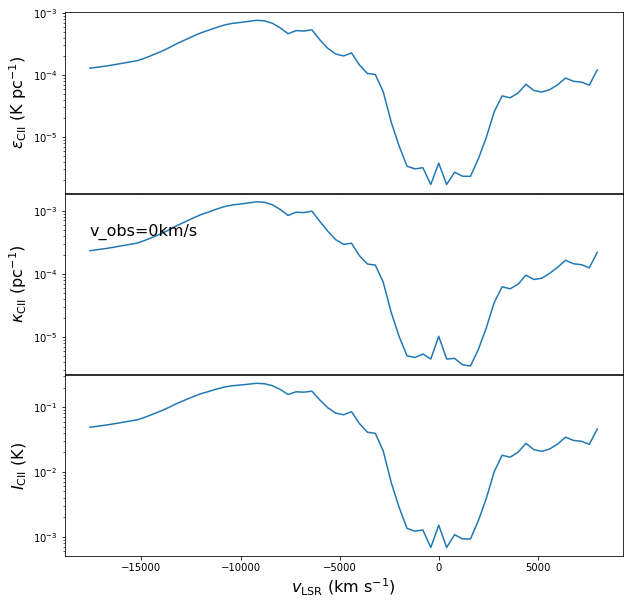

In [32]:
i_vox = ((model.position[:, 0]<8178)&(model.position[:, 1]==0)&(model.position[:, 2]==0))
vel = 0
i_vel = model.map_vel == vel
pos = model.position[i_vox, 0]
eps = model.species_emissivity[i_vox, :, 0]
kap = model.species_absorption[i_vox, :, 0]
intensity = eps/kap*(1-np.exp(-kap*400))
num = eps.shape[0]
print(num)
cmap = cm.get_cmap('viridis')
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
fig.subplots_adjust(hspace=0.005)
ax[0].semilogy(pos, eps[:, i_vel])
ax[1].semilogy(pos, kap[:, i_vel])
ax[2].semilogy(pos, intensity[:, i_vel])
ax[1].text(pos.min(), kap[:, i_vel].mean(), f'v_obs={vel}km/s', fontsize=16)
# for i, e in enumerate(eps[::-1]):
#     ax[0].plot(model.map_vel, e, c=cmap(i/num))
# for i, k in enumerate(kap[::-1]):
#     ax[1].plot(model.map_vel, k, c=cmap(i/num))
# for i, inten in enumerate(intensity[::-1]):
#     ax[2].plot(model.map_vel, inten, c=cmap(i/num))
# plt.plot(model.map_vel, model.species_emissivity[i_center, :, 0][0]/model.species_absorption[i_center, :, 0][0]*(1-np.exp(model.species_absorption[i_center, :, 0][0]*400)))
ax[2].set_xlabel(r'$v_\mathrm{LSR}$ (km s$^{-1}$)', fontsize=16)
ax[0].set_ylabel(r'$\epsilon_\mathrm{CII}$ (K pc$^{-1}$)', fontsize=16)
ax[1].set_ylabel(r'$\kappa_\mathrm{CII}$ (pc$^{-1}$)', fontsize=16)
ax[2].set_ylabel(r'$I_\mathrm{CII}$ (K)', fontsize=16) ;
#ax[0].set_ylim(0, 0.0002)
#ax[1].set_ylim(0, 0.00002)
#ax[2].set_ylim(0, 0.02)

In [43]:
model.species

['C+ 1',
 'C 1',
 'C 2',
 'CO 1',
 'CO 2',
 'CO 3',
 'CO 4',
 'CO 5',
 'CO 6',
 'CO 7',
 'CO 8',
 '13C+ 1',
 '13C 1',
 '13C 2',
 '13CO 1',
 '13CO 2',
 '13CO 3',
 '13CO 4',
 '13CO 5',
 '13CO 6',
 '13CO 7',
 '13CO 8',
 'HCO+ 1',
 'HCO+ 2',
 'HCO+ 3',
 'HCO+ 4',
 'HCO+ 5']

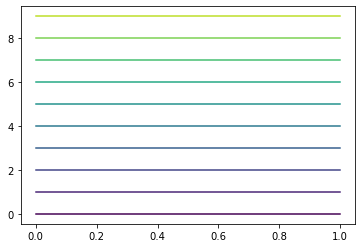

In [73]:
for i in range(10):
    plt.plot((i, i), c=cmap(i/10))

In [73]:
model.los_count

array([18., 25., 39., 80., 80., 80., 39., 25., 18.])

### View distribution

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from kosmatau3d import models
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [42]:
model = models.SyntheticModel(base_dir='/mnt/hpc_backup/yanitski/projects/pdr/KT3_history/MilkyWay/')
model.load_model(directory='r400_f_fuv_gc100.00_r_gc200_disp_gc300/')

Text(0, 0.5, 'max log $\\epsilon_\\mathrm{CII}$')

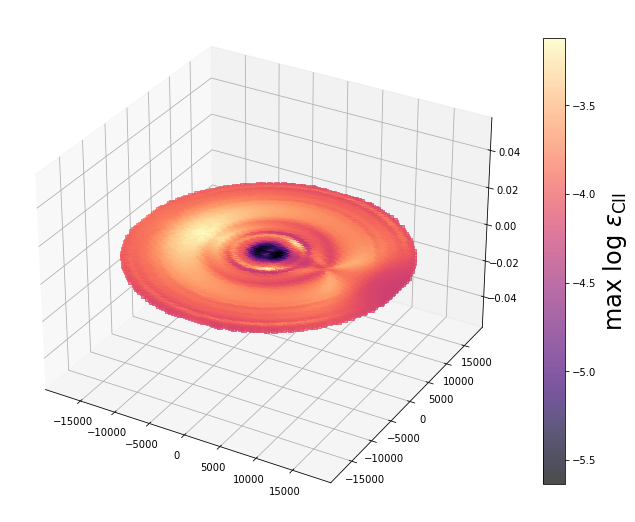

In [43]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

x, y, z = model.position.T
epsilon = model.species_emissivity[:, :, 0].max(1)
kappa = model.species_absorption[:, :, 0].max(1)
intensity = epsilon/kappa * (1-np.exp(-kappa*400))

cmap = ax.scatter(x, y, z, c=np.log10(epsilon), cmap='magma', alpha=0.7, marker='s', s=27)
cbar = fig.colorbar(cmap, fraction=0.04)
cbar.ax.set_ylabel(r'max log $\epsilon_\mathrm{CII}$', fontsize=24)

1.4552706688601096


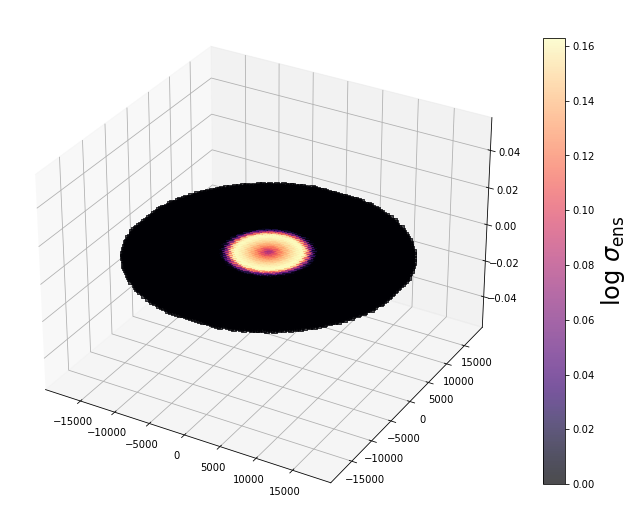

In [44]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

cmap = ax.scatter(x, y, z, c=np.log10(model.fuv[:, 0]), cmap='magma', alpha=0.7, marker='s', s=27)
cbar = fig.colorbar(cmap, fraction=0.04)
cbar.ax.set_ylabel(r'log $\sigma_\mathrm{ens}$', fontsize=24)
print(model.fuv[:, 0].max())

Text(0, 0.5, 'max log $\\kappa_\\mathrm{CII}$')

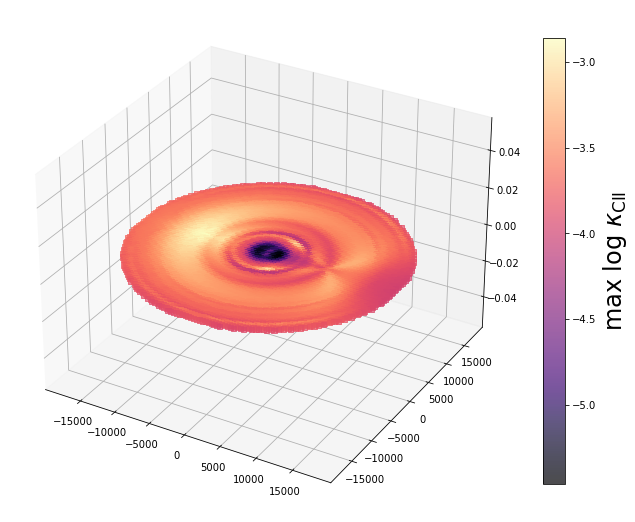

In [32]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

cmap = ax.scatter(x, y, z, c=np.log10(kappa), cmap='magma', alpha=0.7, marker='s', s=27)
cbar = fig.colorbar(cmap, fraction=0.04)
cbar.ax.set_ylabel(r'max log $\kappa_\mathrm{CII}$', fontsize=24)

Text(0, 0.5, 'max log $I_\\mathrm{CII}$')

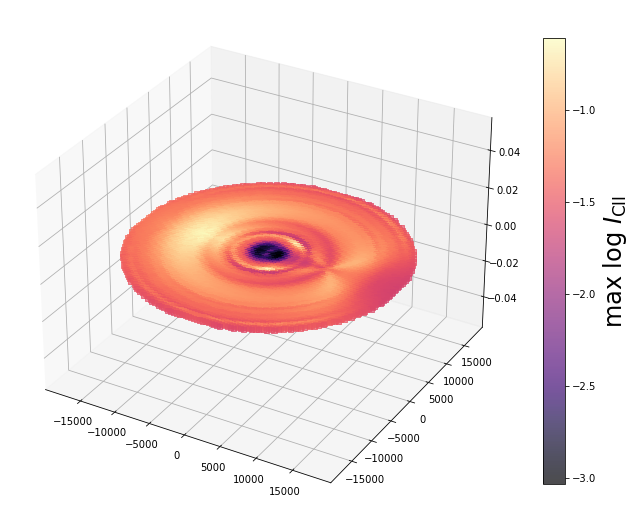

In [33]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

cmap = ax.scatter(x, y, z, c=np.log10(intensity), cmap='magma', alpha=0.7, marker='s', s=27)
cbar = fig.colorbar(cmap, fraction=0.04)
cbar.ax.set_ylabel(r'max log $I_\mathrm{CII}$', fontsize=24)

Text(0, 0.5, '$v_\\mathrm{LSR}$')

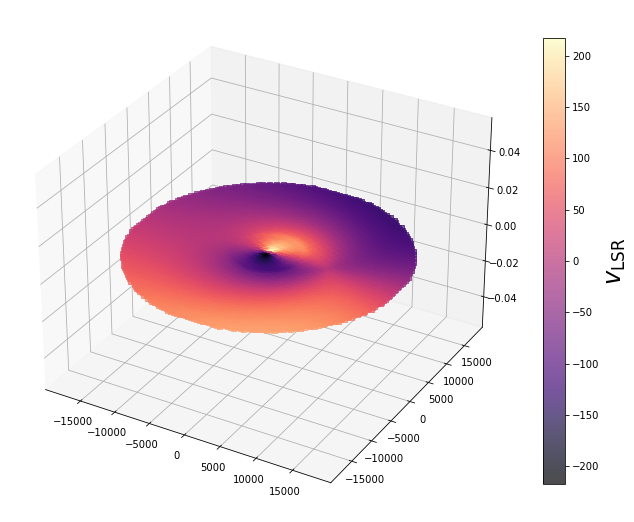

In [34]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

cmap = ax.scatter(x, y, z, c=model.velocity.flatten(), cmap='magma', alpha=0.7, marker='s', s=27)
cbar = fig.colorbar(cmap, fraction=0.04)
cbar.ax.set_ylabel(r'$v_\mathrm{LSR}$', fontsize=24)

Text(0, 0.5, 'log $\\sigma_\\mathrm{ens}$')

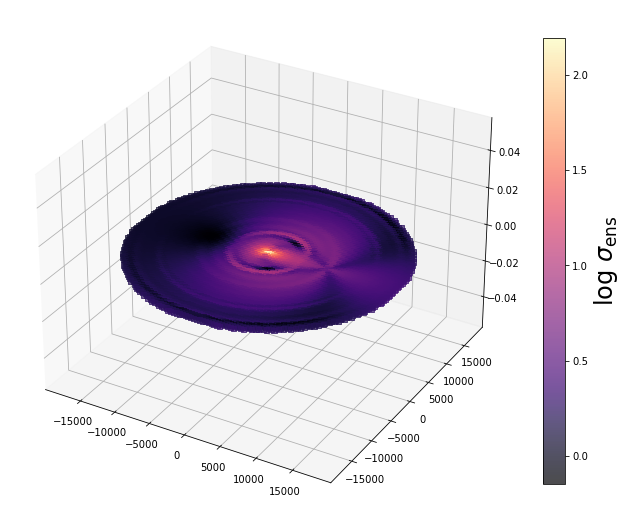

In [35]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

cmap = ax.scatter(x, y, z, c=np.log10(model.ensemble_dispersion.flatten()), cmap='magma', alpha=0.7, marker='s', s=27)
cbar = fig.colorbar(cmap, fraction=0.04)
cbar.ax.set_ylabel(r'log $\sigma_\mathrm{ens}$', fontsize=24)

In [47]:
model.fuv.shape

(6349, 2)

In [37]:
x=y=np.linspace(-200, 200, 5)

In [43]:
np.linalg.norm([x.mean(), y.mean()], axis=0).mean()

0.0

In [47]:
type(np.float64(200))

numpy.float64

## Observational data

In [31]:
base_dir = '/mnt/hpc_backup/yanitski/projects/pdr/observational_data/MilkyWay/COGAL/'

# obs = fits.open(base_dir + 'COGAL_deep_interp.fits')
obs = fits.open(base_dir + 'regridded/temp/co1_test_regridded.fits')
x = np.arange(obs[0].header['NAXIS1'])
y = np.arange(obs[0].header['NAXIS2'])
z = np.arange(obs[0].header['NAXIS3'])
X, Y, Z = np.meshgrid(x, y, z)
fig = go.Figure(data=go.Volume(x=X.flatten(), y=Y.flatten(), z=Z.flatten(), value=obs[0].data.flatten(), surface_count=20))

In [32]:
fig.show()

In [8]:
np.where(np.isnan(obs[0].data))[0].size

42008126

## Examples

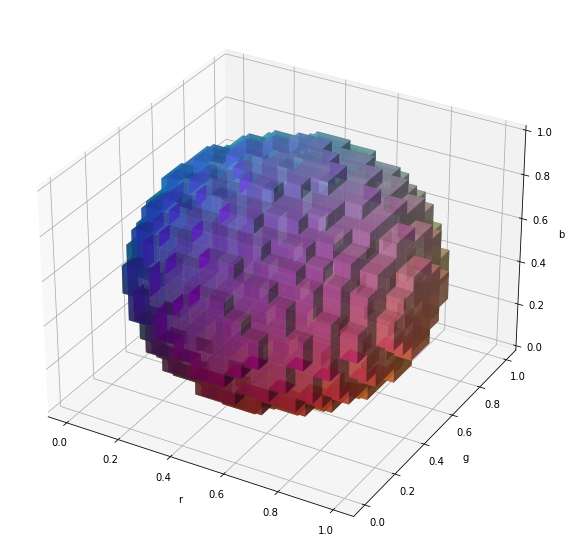

In [81]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np


def midpoints(x):
    sl = ()
    for i in range(x.ndim):
        x = (x[sl + np.index_exp[:-1]] + x[sl + np.index_exp[1:]]) / 2.0
        sl += np.index_exp[:]
    return x

# prepare some coordinates, and attach rgb values to each
r, g, b = np.indices((17, 17, 17)) / 16.0
rc = midpoints(r)
gc = midpoints(g)
bc = midpoints(b)

# define a sphere about [0.5, 0.5, 0.5]
sphere = (rc - 0.5)**2 + (gc - 0.5)**2 + (bc - 0.5)**2 < 0.5**2

# combine the color components
colors = np.zeros(sphere.shape + (3,))
colors[..., 0] = rc
colors[..., 1] = gc
colors[..., 2] = bc

# and plot everything
ax = plt.figure(figsize=(10, 10)).add_subplot(projection='3d')
ax.voxels(r, g, b, sphere,
          facecolors=colors,
          # edgecolors=np.clip(2*colors - 0.5, 0, 1),  # brighter
          alpha=0.7,
          linewidth=0.5)
ax.set(xlabel='r', ylabel='g', zlabel='b') ;

In [79]:
r

array([[[0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
        ...,
        [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ]],

       [[0.0625, 0.0625, 0.0625, ..., 0.0625, 0.0625, 0.0625],
        [0.0625, 0.0625, 0.0625, ..., 0.0625, 0.0625, 0.0625],
        [0.0625, 0.0625, 0.0625, ..., 0.0625, 0.0625, 0.0625],
        ...,
        [0.0625, 0.0625, 0.0625, ..., 0.0625, 0.0625, 0.0625],
        [0.0625, 0.0625, 0.0625, ..., 0.0625, 0.0625, 0.0625],
        [0.0625, 0.0625, 0.0625, ..., 0.0625, 0.0625, 0.0625]],

       [[0.125 , 0.125 , 0.125 , ..., 0.125 , 0.125 , 0.125 ],
        [0.125 , 0.125 , 0.125 , ..., 0.125 , 0.125 , 0.125 ],
        [0.125 , 0.125 , 0.125 , ..., 0.125 , 0.125 , 0.125 ],
        ...,
        [0.1

In [17]:
np.where(np.isnan(values))[0].size

0

In [20]:
values.shape

(40, 40, 40)

In [ ]:
import plotly.graph_objects as go
import numpy as np
X, Y, Z = np.mgrid[-8:8:40j, -8:8:40j, -8:8:40j]
values = np.sin(X*Y*Z) / (X*Y*Z)

fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=values.flatten(),
    isomin=-0.1,
    isomax=0.8,
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=17, # needs to be a large number for good volume rendering
    ))
fig.show()

In [ ]:
import plotly.graph_objects as go
import numpy as np
x, y, z = np.mgrid[-8:8:40j, -8:8:40j, -8:8:40j]
values = np.sin(x*y*z) / (x*y*z)
fig = go.Figure(data=go.Volume(
    x=x.flatten(),
    y=y.flatten(),
    z=z.flatten(),
    value=values.flatten(),
    isomin=0.1,
    isomax=0.8,
    opacity=0.2, # needs to be small to see through all surfaces
    surface_count=20, # needs to be a large number for good volume rendering
    ))
fig.show()

In [ ]:
import plotly.express as px
fig = px.bar(x=["a", "b", "c"], y=[1, 3, 2])
fig.show()